<a href="https://colab.research.google.com/github/amartsin/LungDiseaseRecognition/blob/main/LungDiseasePredictionDenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amartyabhattacharya","key":"f02ad05a9529ab6264d5f9b8b18cb7bd"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 36.9MB/s]
100% 2.29G/2.29G [00:29<00:00, 83.7MB/s]


In [5]:
from zipfile import ZipFile
file_name = "chest-xray-pneumonia.zip"

with ZipFile(file_name , 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [7]:
IMAGE_SIZE=[224,224]

train_path = 'chest_xray/train'
test_path = 'chest_xray/test'


densenet = DenseNet121(input_shape=IMAGE_SIZE +[3],weights='imagenet',include_top=False)


29089792/29084464 [==============================] - 0s 0us/step


In [8]:
for layer in densenet.layers:
  layer.trainable=False
  

In [9]:
folders =glob('chest_xray/train/*')

In [10]:
x= Flatten()(densenet.output)

In [11]:
prediction = Dense(len(folders),activation ='softmax')(x)

In [12]:
model = Model(inputs=densenet.input,outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [13]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer= 'adam',
    metrics= ['accuracy']
)

In [14]:
from keras.preprocessing.image import ImageDataGenerator
 
train_datagen= ImageDataGenerator(1./255,
                                 shear_range = 0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale =1./255)


In [15]:
training_set = train_datagen.flow_from_directory('chest_xray/train',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode= 'categorical')
                                                 

Found 5216 images belonging to 2 classes.


In [16]:
test_set = test_datagen.flow_from_directory('chest_xray/test',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode= 'categorical')
                           

Found 624 images belonging to 2 classes.


In [17]:
r = model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=5,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
163/163 [==============================] - 116s 638ms/step - loss: 11.9075 - accuracy: 0.8068 - val_loss: 11.4509 - val_accuracy: 0.6250
Epoch 2/5
163/163 [==============================] - 102s 627ms/step - loss: 1.5733 - accuracy: 0.9295 - val_loss: 14.9339 - val_accuracy: 0.6250
Epoch 3/5
163/163 [==============================] - 102s 623ms/step - loss: 1.1195 - accuracy: 0.9466 - val_loss: 17.9045 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 102s 626ms/step - loss: 0.9398 - accuracy: 0.9520 - val_loss: 26.0796 - val_accuracy: 0.6250
Epoch 5/5
163/163 [==============================] - 102s 625ms/step - loss: 1.1081 - accuracy: 0.9525 - val_loss: 26.2062 - val_accuracy: 0.6250


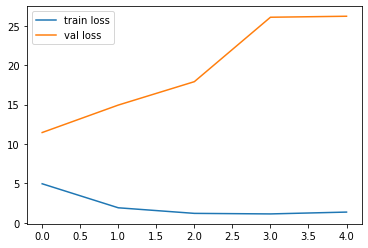

<Figure size 432x288 with 0 Axes>

In [18]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('DensenetLossVal_loss')

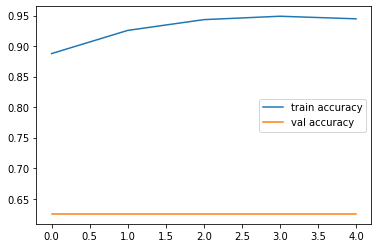

<Figure size 432x288 with 0 Axes>

In [19]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('DensenetAccVal_acc')

In [20]:
test_set = test_datagen.flow_from_directory('chest_xray/val',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode= 'categorical')
                          

Found 16 images belonging to 2 classes.


In [21]:
r = model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


163/163 [==============================] - 96s 591ms/step - loss: 1.3152 - accuracy: 0.9433 - val_loss: 27.4007 - val_accuracy: 0.5000


In [22]:
import tensorflow as tf

from keras.models import load_model

model.save('model_densenet121.h5')